In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [37]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [38]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [40]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [41]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=99999, 
                                        num_workers=6,
                                        shuffle=True
                                        )
                                        
images,labels = next(iter(loader))

In [42]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

torch.Size([256, 1, 32, 32])
Dangerous curve to the right


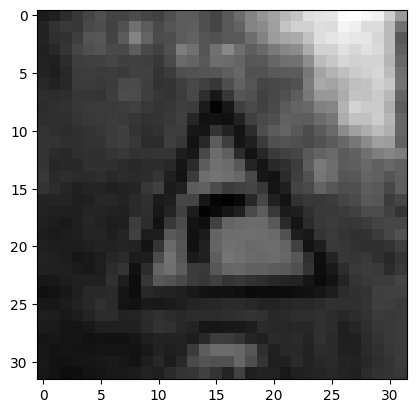

In [43]:
for img,label in train_loader:
    print(img.shape)
    img = to_image(img[0])

    plt.imshow(img,cmap="grey")
    print(LABELS[label[0]])
    break

In [44]:
images = torch.zeros((n_classes,1,_N,_N))

for imgs,lbls in train_loader:
    for img,lbl in zip(imgs,lbls):
        images[lbl] = img

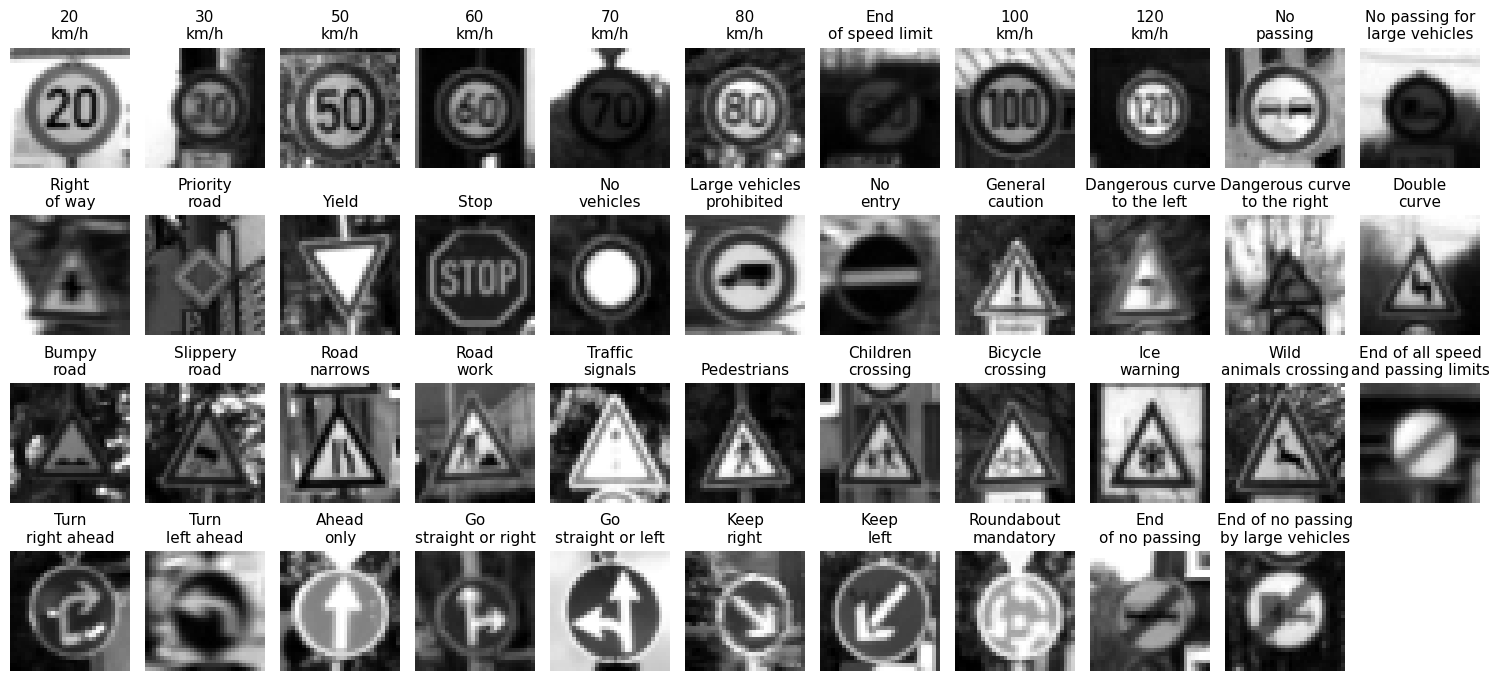

In [45]:
plt.rc('axes', titlesize=11)


plt.figure(figsize=(15,7))

    
for i, img in enumerate(images):
    name = LABELS[i]
    if len(name) > 24:
        name = name[:12] + name[12:].replace(" ","\n",1)
    else:
        name = name.replace(" ","\n",1)
    plt.subplot(4,11, i + 1)
    plt.imshow(to_image(img),cmap="grey")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()

In [46]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.AvgPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],120)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],80)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             156
         AvgPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         AvgPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 120]          48,120
            Linear-6                  [256, 80]           9,680
            Linear-7                  [256, 43]           3,483
Total params: 63,855
Trainable params: 63,855
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 15.87
Params size (MB): 0.24
Estimated Total Size (MB): 17.11
----------------------------------------------------------------


In [47]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [54]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    accuracy = accuracy_score(labels,pred_class)
    print(f"Accuracy: {accuracy:.2f}")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

In [55]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_0.pth",weights_only=True))
evaluate(model)

Accuracy: 0.99
Precision (macro): 0.9874
Recall (macro): 0.9869
F1-score (macro): 0.9869


In [56]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_5.pth",weights_only=True))
evaluate(model)

Accuracy: 0.98
Precision (macro): 0.9805
Recall (macro): 0.9793
F1-score (macro): 0.9794


In [57]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_10.pth",weights_only=True))
evaluate(model)

Accuracy: 0.93
Precision (macro): 0.9395
Recall (macro): 0.9254
F1-score (macro): 0.9279


In [58]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_15.pth",weights_only=True))
evaluate(model)

Accuracy: 0.85
Precision (macro): 0.9005
Recall (macro): 0.8527
F1-score (macro): 0.8656


In [59]:
model = Model().to(device)
model.load_state_dict(torch.load("models/base_epsilon_20.pth",weights_only=True))
evaluate(model)

Accuracy: 0.77
Precision (macro): 0.8766
Recall (macro): 0.7726
F1-score (macro): 0.8002
